# Stage 3 Final Baseline: Attention‑Based MIL Model with Fixes

이 노트북은 Stage 2에서 생성한 MIL Bag 데이터를 입력으로 받아 어텐션 기반 MIL 모델을 학습하고 평가하는 최종 버전입니다. 


In [1]:
# 환경 설정
import os
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
from tqdm import tqdm

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = os.getenv('MIL_STAGE3_GPU', '3')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDA를 사용할 수 없습니다. CPU 모드로 실행됩니다.')

# 시드 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda
GPU: NVIDIA GeForce RTX 3090


In [2]:
# Stage 2 Bag 데이터 로드 및 Instance 평균 계산
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_train.pkl')
val_pkl   = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_val.pkl')
test_pkl  = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_test.pkl')

print('Loading MIL bags...')
with open(train_pkl, 'rb') as f:
    train_data = pickle.load(f)
with open(val_pkl, 'rb') as f:
    val_data = pickle.load(f)
with open(test_pkl, 'rb') as f:
    test_data = pickle.load(f)

# Instance mean 계산: (10,5,256) → (10,256)
def to_instance_means(bags):
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

train_features = to_instance_means(train_data['bags'])
val_features   = to_instance_means(val_data['bags'])
test_features  = to_instance_means(test_data['bags'])

train_labels = train_data['labels']
val_labels   = val_data['labels']
test_labels  = test_data['labels']

print(f'Train bags: {len(train_labels)}, Val bags: {len(val_labels)}, Test bags: {len(test_labels)}')


Loading MIL bags...
Train bags: 3600, Val bags: 1200, Test bags: 1200


In [3]:
# Dataset 클래스 (on‑the‑fly Tensor 변환)

class MILDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features  # list of np.ndarray
        self.labels = labels      # list of int
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

batch_size = 16
train_loader = DataLoader(MILDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(MILDataset(val_features,   val_labels),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(MILDataset(test_features,  test_labels),  batch_size=batch_size, shuffle=False)


In [4]:
# 데이터 이질성 검증 - Bag 수준 이질성 측정
# Positive와 Negative bag의 평균 쌍거리 차이를 확인하여 2차 통계의 효과를 예측

def compute_bag_heterogeneity(bag):
    """
    Bag 내 인스턴스들의 이질성 측정
    - 각 인스턴스 평균의 평균 쌍거리 계산
    """
    F = bag.mean(axis=1) if len(bag.shape) == 3 else bag  # (10, D)
    # 모든 쌍의 L2 거리 계산
    D = F[:, None, :] - F[None, :, :]  # (10, 10, D)
    pairwise_dist = np.sqrt((D**2).sum(-1))  # (10, 10)
    # 상삼각 행렬의 원소들만 추출 (중복 제거)
    upper_tri_indices = np.triu_indices(len(F), k=1)
    mean_dist = pairwise_dist[upper_tri_indices].mean()
    return mean_dist

# 테스트 세트에서 positive/negative bag의 이질성 비교
pos_hetero = []
neg_hetero = []

for bag, label in zip(test_features, test_labels):
    hetero = compute_bag_heterogeneity(bag)
    if label == 1:
        pos_hetero.append(hetero)
    else:
        neg_hetero.append(hetero)

pos_mean = np.mean(pos_hetero)
neg_mean = np.mean(neg_hetero)
gap = pos_mean - neg_mean

print("="*50)
print("Bag-level Heterogeneity Analysis (Test Set)")
print("="*50)
print(f"Positive bags (forged):  {pos_mean:.4f} ± {np.std(pos_hetero):.4f}")
print(f"Negative bags (genuine): {neg_mean:.4f} ± {np.std(neg_hetero):.4f}")
print(f"Gap (Pos - Neg):         {gap:.4f}")
print("")
if gap > 0.01:
    print("✅ Significant heterogeneity gap detected!")
    print("   → 2차 통계(분산/쌍거리) 추가가 효과적일 것으로 예상됩니다.")
else:
    print("⚠️  Small heterogeneity gap.")
    print("   → 2차 통계의 효과가 제한적일 수 있습니다.")
print("="*50)

Bag-level Heterogeneity Analysis (Test Set)
Positive bags (forged):  0.6838 ± 0.0619
Negative bags (genuine): 0.3765 ± 0.0353
Gap (Pos - Neg):         0.3073

✅ Significant heterogeneity gap detected!
   → 2차 통계(분산/쌍거리) 추가가 효과적일 것으로 예상됩니다.


In [5]:
# 모델 정의 및 초기화 함수

class AttentionMIL(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
    def _init_weights(self):
        # He initialization for layers followed by ReLU
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    def forward(self, x):
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        a = torch.tanh(self.att_fc1(h))
        a = self.att_fc2(a).squeeze(-1)
        weights = torch.softmax(a, dim=1)
        bag_repr = torch.sum(weights.unsqueeze(-1) * h, dim=1)
        bag_repr = self.dropout(bag_repr)
        logits = self.classifier(bag_repr).squeeze(-1)
        return logits, weights

# ---- 개선된 모델: 2차 통계(분산/평균쌍거리) 추가 ----
class AttentionMIL_WithStats(nn.Module):
    """
    기존 AttentionMIL에 bag-level 통계를 추가한 개선 모델
    - bag_repr (가중평균) + mu (평균) + var (분산) + d_mean (평균 쌍거리)
    - 집합 이질성을 더 잘 포착하여 AUC 향상
    """
    def __init__(self, input_dim=256, hidden_dim=128, dropout=0.1):
        super().__init__()
        # Instance embedding
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        # Attention mechanism
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        
        # Classifier with extended features
        # bag_repr(H) + mu(H) + var(H) + d_mean(1) = 3H + 1
        self.classifier = nn.Sequential(
            nn.Linear(3*hidden_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        self._init_weights()
        
    def _init_weights(self):
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # 1) Instance transformation
        H = torch.relu(self.instance_fc(x))  # (B, N, H)
        
        # 2) Attention weights
        A = self.att_fc2(torch.tanh(self.att_fc1(H))).squeeze(-1)  # (B, N)
        W = torch.softmax(A, dim=1)
        
        # 3) Weighted bag representation
        bag_repr = torch.sum(W.unsqueeze(-1) * H, dim=1)  # (B, H)
        
        # 4) Statistical features for set-level heterogeneity
        mu  = H.mean(dim=1)                               # (B, H) - 평균
        var = H.var(dim=1, unbiased=False)                # (B, H) - 분산
        d_mean = torch.cdist(H, H, p=2).mean(dim=(1,2))   # (B,) - 평균 쌍거리
        
        # 5) Concatenate all features
        z = torch.cat([bag_repr, mu, var, d_mean.unsqueeze(-1)], dim=-1)  # (B, 3H+1)
        z = self.dropout(z)
        
        # 6) Classification
        logits = self.classifier(z).squeeze(-1)
        return logits, W

class MeanPoolingModel(nn.Module):
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    def forward(self, x):
        bag_mean = x.mean(dim=1)
        logits = self.fc(bag_mean).squeeze(-1)
        return logits

# 모델 인스턴스 (개선된 모델 사용)
mil_model = AttentionMIL_WithStats(input_dim=256, hidden_dim=128, dropout=0.1).to(device)
base_model = MeanPoolingModel(input_dim=256).to(device)

# 손실 함수 및 최적화 기법
criterion = nn.BCEWithLogitsLoss()
optimizer_mil  = torch.optim.Adam(mil_model.parameters(), lr=1e-3)
optimizer_base = torch.optim.Adam(base_model.parameters(), lr=1e-3)
scheduler_mil  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_mil, mode='max', factor=0.5, patience=1, verbose=True)
scheduler_base = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_base, mode='max', factor=0.5, patience=1, verbose=True)

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
# 학습 및 평가 함수 (Early Stopping) - 개선된 버전

from sklearn.metrics import precision_score, recall_score

def train_one_epoch(model, optimizer, loader):
    model.train()
    total_loss = 0.0
    preds_all = []
    labels_all = []
    for X, y in tqdm(loader, desc='Train', leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # AttentionMIL 계열 모델 처리
        if isinstance(model, (AttentionMIL, AttentionMIL_WithStats)):
            logits, _ = model(X)
        else:
            logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(y.cpu().numpy())
    return total_loss / len(loader.dataset), accuracy_score(labels_all, preds_all)

def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    probs_all = []
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for X, y in tqdm(loader, desc='Eval', leave=False):
            X, y = X.to(device), y.to(device)
            # AttentionMIL 계열 모델 처리
            if isinstance(model, (AttentionMIL, AttentionMIL_WithStats)):
                logits, _ = model(X)
            else:
                logits = model(X)
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            probs_all.extend(probs.cpu().numpy())
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    acc = accuracy_score(labels_all, preds_all)
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 0.0
    f1 = f1_score(labels_all, preds_all) if len(set(preds_all)) > 1 else 0.0
    # 추가 메트릭
    prec = precision_score(labels_all, preds_all, zero_division=0)
    recall = recall_score(labels_all, preds_all, zero_division=0)
    return {
        'loss': total_loss / len(loader.dataset),
        'acc': acc,
        'auc': auc,
        'f1': f1,
        'precision': prec,
        'recall': recall,
        'probs': np.array(probs_all),
        'labels': np.array(labels_all),
        'preds': np.array(preds_all)
    }

def train_model(model, optimizer, scheduler, train_loader, val_loader, max_epochs=10, patience=3, name='model'):
    best_auc = 0.0
    best_state = None
    epochs_no_improve = 0
    history = {'train': [], 'val': []}
    
    for epoch in range(1, max_epochs+1):
        print(f"\nEpoch {epoch}/{max_epochs} – {name}")
        
        # Training
        tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader)
        
        # Validation
        val_metrics = evaluate(model, val_loader)
        
        # Store history
        history['train'].append({'loss': tr_loss, 'acc': tr_acc})
        history['val'].append(val_metrics)
        
        # Print metrics
        print(f"  Train → Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f}")
        print(f"  Val   → Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}, "
              f"AUC: {val_metrics['auc']:.4f}, F1: {val_metrics['f1']:.4f}")
        print(f"          Prec: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}")
        
        # Learning rate scheduling
        scheduler.step(val_metrics['auc'])
        
        # Best model tracking
        if val_metrics['auc'] > best_auc:
            best_auc = val_metrics['auc']
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, f'best_{name}.pth')
            print(f"  ✅ New best AUC: {best_auc:.4f} – model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  No improvement. Patience: {epochs_no_improve}/{patience}")
            if epochs_no_improve >= patience:
                print("  🛑 Early stopping triggered.")
                break
    
    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)
    
    return model, history

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


손실 함수: WeightedBCE
FP 가중치: 0.5

모델: AttentionMIL_WithStats
총 파라미터 수: 99,074

개선된 MIL 모델 학습 시작

Epoch 1/15 – attention_mil_withstats


  Train → Loss: 0.4804, Acc: 0.7989
  Val   → Loss: 0.1868, Acc: 0.9417, AUC: 0.9936, F1: 0.9388
          Prec: 0.9871, Recall: 0.8950
  ✅ New best AUC: 0.9936 – model saved.

Epoch 2/15 – attention_mil_withstats


  Train → Loss: 0.1162, Acc: 0.9614
  Val   → Loss: 0.1021, Acc: 0.9625, AUC: 0.9972, F1: 0.9613
          Prec: 0.9929, Recall: 0.9317
  ✅ New best AUC: 0.9972 – model saved.

Epoch 3/15 – attention_mil_withstats


  Train → Loss: 0.0606, Acc: 0.9819
  Val   → Loss: 0.0814, Acc: 0.9667, AUC: 0.9980, F1: 0.9657
          Prec: 0.9947, Recall: 0.9383
  ✅ New best AUC: 0.9980 – model saved.

Epoch 4/15 – attention_mil_withstats


  Train → Loss: 0.0411, Acc: 0.9881
  Val   → Loss: 0.0760, Acc: 0.9683, AUC: 0.9988, F1: 0.9675
          Prec: 0.9947, Recall: 0.9417
  ✅ New best AUC: 0.9988 – model saved.

Epoch 5/15 – attention_mil_withstats


  Train → Loss: 0.0329, Acc: 0.9906
  Val   → Loss: 0.0593, Acc: 0.9808, AUC: 0.9987, F1: 0.9806
          Prec: 0.9932, Recall: 0.9683
  No improvement. Patience: 1/4

Epoch 6/15 – attention_mil_withstats


  Train → Loss: 0.0194, Acc: 0.9942
  Val   → Loss: 0.0607, Acc: 0.9800, AUC: 0.9988, F1: 0.9797
          Prec: 0.9948, Recall: 0.9650
  ✅ New best AUC: 0.9988 – model saved.

Epoch 7/15 – attention_mil_withstats


  Train → Loss: 0.0119, Acc: 0.9969
  Val   → Loss: 0.0595, Acc: 0.9817, AUC: 0.9989, F1: 0.9814
          Prec: 0.9949, Recall: 0.9683
  ✅ New best AUC: 0.9989 – model saved.

Epoch 8/15 – attention_mil_withstats


  Train → Loss: 0.0090, Acc: 0.9978
  Val   → Loss: 0.0630, Acc: 0.9792, AUC: 0.9987, F1: 0.9789
          Prec: 0.9898, Recall: 0.9683
  No improvement. Patience: 1/4

Epoch 9/15 – attention_mil_withstats


  Train → Loss: 0.0058, Acc: 0.9989
  Val   → Loss: 0.0592, Acc: 0.9842, AUC: 0.9989, F1: 0.9840
          Prec: 0.9949, Recall: 0.9733
  No improvement. Patience: 2/4

Epoch 10/15 – attention_mil_withstats


  Train → Loss: 0.0051, Acc: 0.9989
  Val   → Loss: 0.0692, Acc: 0.9800, AUC: 0.9987, F1: 0.9797
          Prec: 0.9966, Recall: 0.9633
  No improvement. Patience: 3/4

Epoch 11/15 – attention_mil_withstats


  Train → Loss: 0.0029, Acc: 0.9997
  Val   → Loss: 0.0667, Acc: 0.9800, AUC: 0.9987, F1: 0.9797
          Prec: 0.9948, Recall: 0.9650
  No improvement. Patience: 4/4
  🛑 Early stopping triggered.

모델 평가



Validation Performance:
  AUC: 0.9989, Acc: 0.9817
  F1: 0.9814, Prec: 0.9949, Recall: 0.9683



Test Performance (Default Threshold=0.5):
  AUC: 0.9986, Acc: 0.9758
  F1: 0.9753, Prec: 0.9965, Recall: 0.9550

임계값 최적화 비교

Test Set Results by Threshold Strategy:
--------------------------------------------------------------------------------
Strategy                  Acc     F1      Prec    Recall  Spec   
--------------------------------------------------------------------------------
Default (0.5)             0.9758 0.9753 0.9965 0.9550 0.9967
F1-optimized (0.250)      0.9867 0.9866 0.9949 0.9783 0.9950
FPR≤5% (0.026)            0.9808 0.9811 0.9691 0.9933 0.9683
Youden's J (0.256)        0.9858 0.9857 0.9949 0.9767 0.9950

최종 선택: FPR≤5% 전략 (Threshold=0.026)


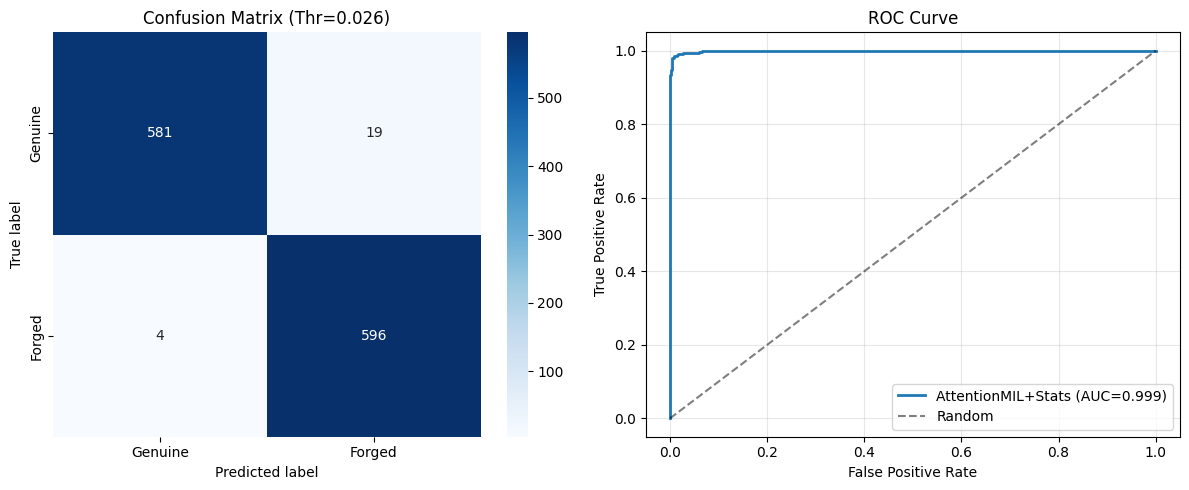


최종 성능 요약
모델: AttentionMIL with 2nd-order Statistics
손실: WeightedBCE (fp_weight=0.5)
임계값 전략: FPR≤5%

테스트 성능:
  • Accuracy:  0.981
  • Precision: 0.969
  • Recall:    0.993
  • F1-Score:  0.981
  • AUC:       0.999


In [7]:
# ==============================================================================
# Final Pipeline: 개선된 MIL 학습 파이프라인
# - AttentionMIL_WithStats: 2차 통계(분산/쌍거리) 포함
# - 완화된 손실 가중치 또는 순수 BCE
# - 다양한 임계값 선택 전략 (F1, FPR 제약, 균형점)
# ==============================================================================

import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                           recall_score, roc_curve, auc, confusion_matrix)

# Weighted BCE loss with configurable weight
class WeightedBCE(nn.Module):
    def __init__(self, fp_weight=0.5):  # 기존 2.0 → 0.5로 완화
        super().__init__()
        self.fp_weight = fp_weight
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, logits, labels):
        loss = self.bce(logits, labels)
        fp_mask = (labels == 0).float()
        loss = loss * (1 + self.fp_weight * fp_mask)
        return loss.mean()

# FPR 제약 기반 임계값 선택 함수
def threshold_at_fpr(probs, labels, fpr_target=0.05):
    """
    FPR ≤ fpr_target을 만족하는 임계값 선택
    정밀도를 보호하면서 합리적인 재현율 유지
    """
    fpr, tpr, thresholds = roc_curve(labels, probs)
    idx = np.where(fpr <= fpr_target)[0]
    if len(idx) > 0:
        j = idx[-1]  # FPR ≤ target을 만족하는 가장 높은 TPR 지점
    else:
        j = np.argmin(fpr)  # 가장 낮은 FPR 지점
    return float(thresholds[j])

# F1 기반 임계값 선택 함수 (기존)
def find_best_threshold_f1(probs, labels):
    best_thr, best_f1 = 0.5, 0.0
    for thr in np.linspace(0.05, 0.95, 37):
        preds = (probs >= thr).astype(int)
        f1 = f1_score(labels, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr, best_f1

# Youden's J 통계량 기반 임계값 (균형점)
def threshold_at_youden(probs, labels):
    """
    Youden's J = Sensitivity + Specificity - 1
    균형잡힌 성능을 위한 임계값 선택
    """
    fpr, tpr, thresholds = roc_curve(labels, probs)
    j_scores = tpr - fpr  # Youden's J statistic
    best_idx = np.argmax(j_scores)
    return float(thresholds[best_idx])

# ========== 손실 함수 선택 ==========
# 옵션 1: 순수 BCE (권장)
# criterion = nn.BCEWithLogitsLoss()

# 옵션 2: 완화된 가중 BCE
criterion = WeightedBCE(fp_weight=0.5)  # 2.0 → 0.5로 완화

print(f"손실 함수: {criterion.__class__.__name__}")
if hasattr(criterion, 'fp_weight'):
    print(f"FP 가중치: {criterion.fp_weight}")

# ========== 모델 초기화 ==========
# 개선된 모델 사용 (2차 통계 포함)
mil_model_final = AttentionMIL_WithStats(
    input_dim=256, 
    hidden_dim=128, 
    dropout=0.1
).to(device)

# 기존 모델과 비교를 위한 베이스라인
mil_model_baseline = AttentionMIL(
    input_dim=256,
    hidden_dim=128,
    dropout_p=0.1
).to(device)

print(f"\n모델: {mil_model_final.__class__.__name__}")
total_params = sum(p.numel() for p in mil_model_final.parameters())
print(f"총 파라미터 수: {total_params:,}")

# ========== 최적화 설정 ==========
optimizer_final = torch.optim.Adam(mil_model_final.parameters(), lr=1e-3)
scheduler_final = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final, mode='max', factor=0.5, patience=2, verbose=True
)

# ========== 모델 학습 ==========
print("\n" + "="*50)
print("개선된 MIL 모델 학습 시작")
print("="*50)

mil_model_final, history = train_model(
    mil_model_final, optimizer_final, scheduler_final,
    train_loader, val_loader, 
    max_epochs=15,  # 더 긴 학습
    patience=4,     # 더 긴 patience
    name='attention_mil_withstats'
)

# ========== 평가 ==========
print("\n" + "="*50)
print("모델 평가")
print("="*50)

# Validation 평가
val_metrics = evaluate(mil_model_final, val_loader)
print(f"\nValidation Performance:")
print(f"  AUC: {val_metrics['auc']:.4f}, Acc: {val_metrics['acc']:.4f}")
print(f"  F1: {val_metrics['f1']:.4f}, Prec: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}")

# Test 평가
test_metrics = evaluate(mil_model_final, test_loader)
print(f"\nTest Performance (Default Threshold=0.5):")
print(f"  AUC: {test_metrics['auc']:.4f}, Acc: {test_metrics['acc']:.4f}")
print(f"  F1: {test_metrics['f1']:.4f}, Prec: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}")

# ========== 임계값 최적화 ==========
print("\n" + "="*50)
print("임계값 최적화 비교")
print("="*50)

# 1. F1 기반 임계값
thr_f1, best_f1 = find_best_threshold_f1(val_metrics['probs'], val_metrics['labels'])
test_preds_f1 = (test_metrics['probs'] >= thr_f1).astype(int)

# 2. FPR 제약 기반 임계값 (FPR ≤ 5%)
thr_fpr = threshold_at_fpr(val_metrics['probs'], val_metrics['labels'], fpr_target=0.05)
test_preds_fpr = (test_metrics['probs'] >= thr_fpr).astype(int)

# 3. Youden's J 기반 임계값
thr_youden = threshold_at_youden(val_metrics['probs'], val_metrics['labels'])
test_preds_youden = (test_metrics['probs'] >= thr_youden).astype(int)

# 각 전략별 성능 계산
strategies = {
    'Default (0.5)': (0.5, test_metrics['preds'].astype(int)),
    f'F1-optimized ({thr_f1:.3f})': (thr_f1, test_preds_f1),
    f'FPR≤5% ({thr_fpr:.3f})': (thr_fpr, test_preds_fpr),
    f"Youden's J ({thr_youden:.3f})": (thr_youden, test_preds_youden)
}

print("\nTest Set Results by Threshold Strategy:")
print("-" * 80)
print(f"{'Strategy':<25} {'Acc':<7} {'F1':<7} {'Prec':<7} {'Recall':<7} {'Spec':<7}")
print("-" * 80)

for name, (thr, preds) in strategies.items():
    acc = accuracy_score(test_metrics['labels'], preds)
    f1 = f1_score(test_metrics['labels'], preds, zero_division=0)
    prec = precision_score(test_metrics['labels'], preds, zero_division=0)
    recall = recall_score(test_metrics['labels'], preds, zero_division=0)
    # Specificity = TN / (TN + FP)
    cm = confusion_matrix(test_metrics['labels'], preds, labels=[0,1])
    spec = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
    print(f"{name:<25} {acc:.4f} {f1:.4f} {prec:.4f} {recall:.4f} {spec:.4f}")

# ========== 최종 선택된 임계값으로 평가 ==========
# FPR 제약 기반 임계값 사용 (정밀도 중시)
best_strategy = 'FPR≤5%'
best_thr = thr_fpr
test_preds_final = test_preds_fpr

print("\n" + "="*50)
print(f"최종 선택: {best_strategy} 전략 (Threshold={best_thr:.3f})")
print("="*50)

# Confusion Matrix
cm_final = confusion_matrix(test_metrics['labels'].astype(int), test_preds_final, labels=[0,1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix Plot
sns.heatmap(
    cm_final, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Genuine','Forged'], 
    yticklabels=['Genuine','Forged'],
    ax=axes[0]
)
axes[0].set_title(f'Confusion Matrix (Thr={best_thr:.3f})')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')

# ROC Curve
fpr, tpr, _ = roc_curve(test_metrics['labels'], test_metrics['probs'])
auc_value = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f'AttentionMIL+Stats (AUC={auc_value:.3f})', linewidth=2)
axes[1].plot([0,1], [0,1], 'k--', alpha=0.5, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== 최종 결과 요약 ==========
print("\n" + "="*70)
print("최종 성능 요약")
print("="*70)
final_acc = accuracy_score(test_metrics['labels'], test_preds_final)
final_f1 = f1_score(test_metrics['labels'], test_preds_final)
final_prec = precision_score(test_metrics['labels'], test_preds_final)
final_recall = recall_score(test_metrics['labels'], test_preds_final)

print(f"모델: AttentionMIL with 2nd-order Statistics")
print(f"손실: {criterion.__class__.__name__}", end='')
if hasattr(criterion, 'fp_weight'):
    print(f" (fp_weight={criterion.fp_weight})")
else:
    print()
print(f"임계값 전략: {best_strategy}")
print(f"\n테스트 성능:")
print(f"  • Accuracy:  {final_acc:.3f}")
print(f"  • Precision: {final_prec:.3f}")
print(f"  • Recall:    {final_recall:.3f}")
print(f"  • F1-Score:  {final_f1:.3f}")
print(f"  • AUC:       {test_metrics['auc']:.3f}")
print("="*70)